# Pothole Detection using YOLOv7

We carry out the following training experiments using YOLOv7 on the pothole dataset in this notebook:
* YOLOv7 Tiny model fixed resolution training.
* YOLOv7 Tiny model multi-resolution training.
* YOLOv7 normam model fixed resolution training.
* YOLOv7 normal model multi-resolution training.

In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import random
import cv2

In [2]:
import torch
torch.cuda.is_available()

True

## Download and Extract the Dataset

In [3]:
# Download the dataset.
!wget https://learnopencv.s3.us-west-2.amazonaws.com/pothole_dataset.zip 

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# Extract the dataset.
!unzip -q pothole_dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Visualize Images from the Dataset

In [5]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [6]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))
                
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [7]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))
    all_labels = glob.glob(label_paths)
    
    all_images.sort()
    all_labels.sort()

    num_images = len(all_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_images[j])
        with open(all_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

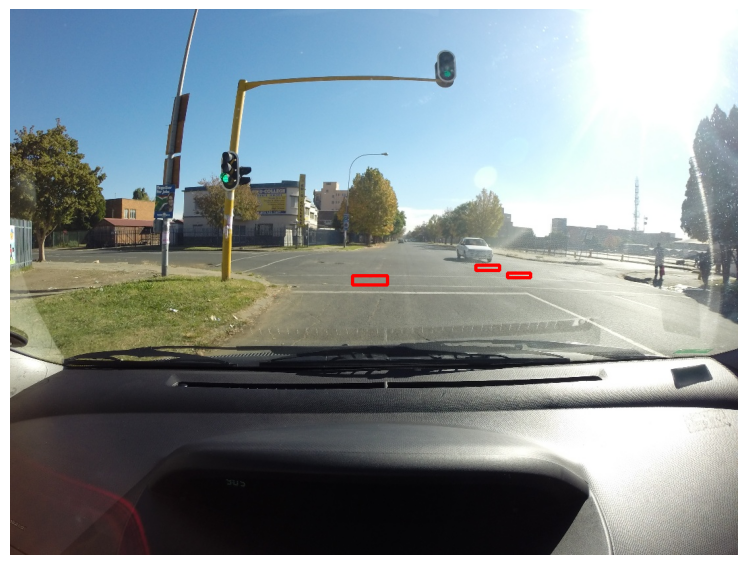

In [8]:
# Visualize a few training images.
plot(
    image_paths='pothole_dataset/images/train/', 
    label_paths='pothole_dataset/labels/train/*.txt',
    num_samples=1,
)

## Clone the YOLOv7 GitHub Repository

In [9]:
if not os.path.exists('yolov7'):
    !git clone https://github.com/Ryukijano/yolov7.git

In [10]:
%cd yolov7

g:\WORK\YOLOV7\yolov7\yolov7


In [11]:
!pip install -r requirements.txt
!pip uninstall wandb -y

## Create the Data YAML File

In [12]:
%%writefile data/pothole.yaml
train: ../pothole_dataset/images/train 
val: ../pothole_dataset/images/valid
test: ../pothole_dataset/images/test

# Classes
nc: 1  # number of classes
names: ['pothole']  # class names

Overwriting data/pothole.yaml


## YOLOv7 Tiny Model Fixed Resolution Training

In [13]:
!pip install wget
# Download the Tiny model weights.
!python -m wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt


Saved under yolov7-tiny (1).pt


In [14]:
%%writefile cfg/training/yolov7_pothole-tiny.yaml
# parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# yolov7-tiny backbone
backbone:
  # [from, number, module, args] c2, k=1, s=1, p=None, g=1, act=True
  [[-1, 1, Conv, [32, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 0-P1/2  
  
   [-1, 1, Conv, [64, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 1-P2/4    
   
   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 7
   
   [-1, 1, MP, []],  # 8-P3/8
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 14
   
   [-1, 1, MP, []],  # 15-P4/16
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 21
   
   [-1, 1, MP, []],  # 22-P5/32
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 28
  ]

# yolov7-tiny head
head:
  [[-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, SP, [5]],
   [-2, 1, SP, [9]],
   [-3, 1, SP, [13]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -7], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 37
  
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [21, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 47
  
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [14, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P3
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 57
   
   [-1, 1, Conv, [128, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, 47], 1, Concat, [1]],
   
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 65
   
   [-1, 1, Conv, [256, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, 37], 1, Concat, [1]],
   
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 73
      
   [57, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [65, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [73, 1, Conv, [512, 3, 1, None, 1, nn.LeakyReLU(0.1)]],

   [[74,75,76], 1, IDetect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

Overwriting cfg/training/yolov7_pothole-tiny.yaml


In [26]:
!python train.py --epochs 100 --workers 20 --device 0 --batch-size 50 \
--data data/pothole.yaml --img 640 640 --cfg cfg/training/yolov7_pothole-tiny.yaml \
--weights 'yolov7-tiny.pt' --name yolov7_tiny_pothole_fixed_res --hyp data/hyp.scratch.tiny.yaml

In [16]:
!python test.py --weights runs/train/yolov7_tiny_pothole_fixed_res/weights/best.pt --task test --data data/pothole.yaml

Namespace(weights=['runs/train/yolov7_tiny_pothole_fixed_res/weights/best.pt'], data='data/pothole.yaml', batch_size=32, img_size=640, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='exp', exist_ok=False, no_trace=False, v5_metric=False)


YOLOR  072f76c torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11263.8125MB)

Traceback (most recent call last):
  File "c:\Users\Gyana\anaconda3\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\Users\Gyana\anaconda3\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\Users\Gyana\anaconda3\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Gyana\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "c:\Users\Gyana\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 386, in _make_request
  

In [17]:
!python detect.py --weights runs/train/yolov7_tiny_pothole_fixed_res/weights/best.pt --conf 0.25 --img-size 640 --source ../pothole_dataset/images/test/G0010124.JPG

Namespace(weights=['runs/train/yolov7_tiny_pothole_fixed_res/weights/best.pt'], source='../pothole_dataset/images/test/G0010124.JPG', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)


YOLOR  072f76c torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11263.8125MB)

Traceback (most recent call last):
  File "g:\WORK\YOLOV7\yolov7\yolov7\utils\google_utils.py", line 26, in attempt_download
    assets = [x['name'] for x in response['assets']]  # release assets
KeyError: 'assets'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "g:\WORK\YOLOV7\yolov7\yolov7\detect.py", line 196, in <module>
    detect()
  File "g:\WORK\YOLOV7\yolov7\yolov7\detect.py", line 34, in detect
    model = attempt_load(weights, map_location=device)  # load FP32 model
  File "g:\WORK\YOLOV7\yolov7\yolov7\models\experimental.py", line 251, in attempt_load
    attempt_download(w)
  File "g:\WORK\YOLOV7\yolov7\yolov7\utils\google_utils.py", line 31, in attempt_download
    tag = subprocess.check_output('git tag', shell=True).decode().split()[-1]
IndexError: list index out of range


## YOLOv7 Tiny Model Multi-Resolution Training

In [18]:
!python train.py --epochs 100 --workers 4 --device 0 --batch-size 32 \
--data data/pothole.yaml --img 640 640 --cfg cfg/training/yolov7_pothole-tiny.yaml \
--weights 'yolov7-tiny.pt' --name yolov7_tiny_pothole_multi_res --hyp data/hyp.scratch.tiny.yaml \
--multi-scale

wandb: Install Weights & Biases for YOLOR logging with 'pip install wandb' (recommended)

autoanchor: Analyzing anchors... anchors/target = 2.49, Best Possible Recall (BPR) = 0.8156. Attempting to improve anchors, please wait...
autoanchor: WARNING: Extremely small objects found. 538 of 3497 labels are < 3 pixels in size.
autoanchor: Running kmeans for 9 anchors on 3497 points...
autoanchor: thr=0.25: 1.0000 best possible recall, 3.29 anchors past thr
autoanchor: n=9, img_size=640, metric_all=0.239/0.713-mean/best, past_thr=0.507-mean: 13,4,  29,9,  59,20,  93,48,  187,60,  161,114,  335,113,  243,202,  501,245
autoanchor: thr=0.25: 1.0000 best possible recall, 3.75 anchors past thr
autoanchor: n=9, img_size=640, metric_all=0.268/0.749-mean/best, past_thr=0.516-mean: 9,3,  17,5,  28,9,  56,17,  87,46,  162,56,  159,118,  293,120,  382,215
autoanchor: New anchors saved to model. Update model *.yaml to use these anchors in the future.



YOLOR  072f76c torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11263.8125MB)

Namespace(weights="'yolov7-tiny.pt'", cfg='cfg/training/yolov7_pothole-tiny.yaml', data='data/pothole.yaml', hyp='data/hyp.scratch.tiny.yaml', epochs=100, batch_size=32, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=True, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=4, project='runs/train', entity=None, name='yolov7_tiny_pothole_multi_res', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], v5_metric=False, world_size=1, global_rank=-1, save_dir='runs\\train\\yolov7_tiny_pothole_multi_res', total_batch_size=32)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.01, m

In [19]:
!python test.py --weights runs/train/yolov7_tiny_pothole_multi_res/weights/best.pt --task test --data data/pothole.yaml

Namespace(weights=['runs/train/yolov7_tiny_pothole_multi_res/weights/best.pt'], data='data/pothole.yaml', batch_size=32, img_size=640, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='exp', exist_ok=False, no_trace=False, v5_metric=False)


YOLOR  072f76c torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11263.8125MB)

Traceback (most recent call last):
  File "g:\WORK\YOLOV7\yolov7\yolov7\utils\google_utils.py", line 26, in attempt_download
    assets = [x['name'] for x in response['assets']]  # release assets
KeyError: 'assets'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "g:\WORK\YOLOV7\yolov7\yolov7\test.py", line 319, in <module>
    test(opt.data,
  File "g:\WORK\YOLOV7\yolov7\yolov7\test.py", line 58, in test
    model = attempt_load(weights, map_location=device)  # load FP32 model
  File "g:\WORK\YOLOV7\yolov7\yolov7\models\experimental.py", line 251, in attempt_load
    attempt_download(w)
  File "g:\WORK\YOLOV7\yolov7\yolov7\utils\google_utils.py", line 31, in attempt_download
    tag = subprocess.check_output('git tag', shell=True).decode().split()[-1]
IndexError: list index out of range


## YOLOv7 Normal Model Fixed Resolution Training

In [20]:
%%writefile cfg/training/yolov7_pothole.yaml
# parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [12,16, 19,36, 40,28]  # P3/8
  - [36,75, 76,55, 72,146]  # P4/16
  - [142,110, 192,243, 459,401]  # P5/32

# yolov7 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [32, 3, 1]],  # 0
  
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2      
   [-1, 1, Conv, [64, 3, 1]],
   
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4  
   [-1, 1, Conv, [64, 1, 1]],
   [-2, 1, Conv, [64, 1, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]],  # 11
         
   [-1, 1, MP, []],
   [-1, 1, Conv, [128, 1, 1]],
   [-3, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 2]],
   [[-1, -3], 1, Concat, [1]],  # 16-P3/8  
   [-1, 1, Conv, [128, 1, 1]],
   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1]],  # 24
         
   [-1, 1, MP, []],
   [-1, 1, Conv, [256, 1, 1]],
   [-3, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [256, 3, 2]],
   [[-1, -3], 1, Concat, [1]],  # 29-P4/16  
   [-1, 1, Conv, [256, 1, 1]],
   [-2, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [1024, 1, 1]],  # 37
         
   [-1, 1, MP, []],
   [-1, 1, Conv, [512, 1, 1]],
   [-3, 1, Conv, [512, 1, 1]],
   [-1, 1, Conv, [512, 3, 2]],
   [[-1, -3], 1, Concat, [1]],  # 42-P5/32  
   [-1, 1, Conv, [256, 1, 1]],
   [-2, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [1024, 1, 1]],  # 50
  ]

# yolov7 head
head:
  [[-1, 1, SPPCSPC, [512]], # 51
  
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [37, 1, Conv, [256, 1, 1]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [256, 1, 1]],
   [-2, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]], # 63
   
   [-1, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [24, 1, Conv, [128, 1, 1]], # route backbone P3
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [128, 1, 1]],
   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1]], # 75
      
   [-1, 1, MP, []],
   [-1, 1, Conv, [128, 1, 1]],
   [-3, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 2]],
   [[-1, -3, 63], 1, Concat, [1]],
   
   [-1, 1, Conv, [256, 1, 1]],
   [-2, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]], # 88
      
   [-1, 1, MP, []],
   [-1, 1, Conv, [256, 1, 1]],
   [-3, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [256, 3, 2]],
   [[-1, -3, 51], 1, Concat, [1]],
   
   [-1, 1, Conv, [512, 1, 1]],
   [-2, 1, Conv, [512, 1, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1]], # 101
   
   [75, 1, RepConv, [256, 3, 1]],
   [88, 1, RepConv, [512, 3, 1]],
   [101, 1, RepConv, [1024, 3, 1]],

   [[102,103,104], 1, IDetect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

Writing cfg/training/yolov7_pothole.yaml


In [21]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
!python train.py --epochs 100 --workers 4 --device 0 --batch-size 16 --data data/pothole.yaml \
--img 640 640 --cfg cfg/training/yolov7_pothole.yaml --weights 'yolov7_training.pt' \
--name yolov7_pothole_fixed_res --hyp data/hyp.scratch.custom.yaml

wandb: Install Weights & Biases for YOLOR logging with 'pip install wandb' (recommended)

autoanchor: Analyzing anchors... anchors/target = 2.30, Best Possible Recall (BPR) = 0.7486. Attempting to improve anchors, please wait...
autoanchor: WARNING: Extremely small objects found. 538 of 3497 labels are < 3 pixels in size.
autoanchor: Running kmeans for 9 anchors on 3497 points...
autoanchor: thr=0.25: 1.0000 best possible recall, 3.29 anchors past thr
autoanchor: n=9, img_size=640, metric_all=0.239/0.713-mean/best, past_thr=0.507-mean: 13,4,  29,9,  59,20,  93,48,  187,60,  161,114,  335,113,  243,202,  501,245
autoanchor: thr=0.25: 1.0000 best possible recall, 3.75 anchors past thr
autoanchor: n=9, img_size=640, metric_all=0.268/0.749-mean/best, past_thr=0.516-mean: 9,3,  17,5,  28,9,  56,17,  87,46,  162,56,  159,118,  293,120,  382,215
autoanchor: New anchors saved to model. Update model *.yaml to use these anchors in the future.



YOLOR  072f76c torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11263.8125MB)

Namespace(weights="'yolov7_training.pt'", cfg='cfg/training/yolov7_pothole.yaml', data='data/pothole.yaml', hyp='data/hyp.scratch.custom.yaml', epochs=100, batch_size=16, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=4, project='runs/train', entity=None, name='yolov7_pothole_fixed_res', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], v5_metric=False, world_size=1, global_rank=-1, save_dir='runs\\train\\yolov7_pothole_fixed_res', total_batch_size=16)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0

In [23]:
!python test.py --weights runs/train/yolov7_pothole_fixed_res/weights/best.pt --task test --data data/pothole.yaml

Namespace(weights=['runs/train/yolov7_pothole_fixed_res/weights/best.pt'], data='data/pothole.yaml', batch_size=32, img_size=640, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='exp', exist_ok=False, no_trace=False, v5_metric=False)


YOLOR  072f76c torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11263.8125MB)

Traceback (most recent call last):
  File "g:\WORK\YOLOV7\yolov7\yolov7\utils\google_utils.py", line 26, in attempt_download
    assets = [x['name'] for x in response['assets']]  # release assets
KeyError: 'assets'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "g:\WORK\YOLOV7\yolov7\yolov7\test.py", line 319, in <module>
    test(opt.data,
  File "g:\WORK\YOLOV7\yolov7\yolov7\test.py", line 58, in test
    model = attempt_load(weights, map_location=device)  # load FP32 model
  File "g:\WORK\YOLOV7\yolov7\yolov7\models\experimental.py", line 251, in attempt_load
    attempt_download(w)
  File "g:\WORK\YOLOV7\yolov7\yolov7\utils\google_utils.py", line 31, in attempt_download
    tag = subprocess.check_output('git tag', shell=True).decode().split()[-1]
IndexError: list index out of range


## YOLOv7 Normal Model Multi-Resolution Training

In [24]:
!python train.py --epochs 100 --workers 4 --device 0 --batch-size 8 --data data/pothole.yaml \
--img 640 640 --cfg cfg/training/yolov7_pothole.yaml --weights 'yolov7_training.pt' \
--name yolov7_pothole_multi_res --hyp data/hyp.scratch.custom.yaml \
--multi-scale

wandb: Install Weights & Biases for YOLOR logging with 'pip install wandb' (recommended)

autoanchor: Analyzing anchors... anchors/target = 2.30, Best Possible Recall (BPR) = 0.7486. Attempting to improve anchors, please wait...
autoanchor: WARNING: Extremely small objects found. 538 of 3497 labels are < 3 pixels in size.
autoanchor: Running kmeans for 9 anchors on 3497 points...
autoanchor: thr=0.25: 1.0000 best possible recall, 3.29 anchors past thr
autoanchor: n=9, img_size=640, metric_all=0.239/0.713-mean/best, past_thr=0.507-mean: 13,4,  29,9,  59,20,  93,48,  187,60,  161,114,  335,113,  243,202,  501,245
autoanchor: thr=0.25: 1.0000 best possible recall, 3.75 anchors past thr
autoanchor: n=9, img_size=640, metric_all=0.268/0.749-mean/best, past_thr=0.516-mean: 9,3,  17,5,  28,9,  56,17,  87,46,  162,56,  159,118,  293,120,  382,215
autoanchor: New anchors saved to model. Update model *.yaml to use these anchors in the future.



YOLOR  072f76c torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11263.8125MB)

Namespace(weights="'yolov7_training.pt'", cfg='cfg/training/yolov7_pothole.yaml', data='data/pothole.yaml', hyp='data/hyp.scratch.custom.yaml', epochs=100, batch_size=8, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=True, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=4, project='runs/train', entity=None, name='yolov7_pothole_multi_res', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], v5_metric=False, world_size=1, global_rank=-1, save_dir='runs\\train\\yolov7_pothole_multi_res', total_batch_size=8)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.93

In [25]:
!python test.py --weights runs/train/yolov7_pothole_multi_res/weights/best.pt --task test --data data/pothole.yaml

Namespace(weights=['runs/train/yolov7_pothole_multi_res/weights/best.pt'], data='data/pothole.yaml', batch_size=32, img_size=640, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='exp', exist_ok=False, no_trace=False, v5_metric=False)


YOLOR  072f76c torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11263.8125MB)

Traceback (most recent call last):
  File "g:\WORK\YOLOV7\yolov7\yolov7\utils\google_utils.py", line 26, in attempt_download
    assets = [x['name'] for x in response['assets']]  # release assets
KeyError: 'assets'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "g:\WORK\YOLOV7\yolov7\yolov7\test.py", line 319, in <module>
    test(opt.data,
  File "g:\WORK\YOLOV7\yolov7\yolov7\test.py", line 58, in test
    model = attempt_load(weights, map_location=device)  # load FP32 model
  File "g:\WORK\YOLOV7\yolov7\yolov7\models\experimental.py", line 251, in attempt_load
    attempt_download(w)
  File "g:\WORK\YOLOV7\yolov7\yolov7\utils\google_utils.py", line 31, in attempt_download
    tag = subprocess.check_output('git tag', shell=True).decode().split()[-1]
IndexError: list index out of range
